# CNNs en Google Street View
En esta sección se trabajará con un dataset conocido como SVHN (**Street View House Numbers**), el cual contiene imágenes naturales de dígitos de direcciones obtenidos desde la aplicación de Google, *Street View*. El dataset contiene más de 600 mil imágenes de entrenamiento y 26.032 imágenes de test, aunque en esta tarea se trabajará con una pequeña muestra como conjunto de entrenamiento debido a lo costoso computacionalmente del trabajar con las 600 mil imágenes, trabajando con 73.257 imágenes de entrenamiento y 531.131 extras.

In [1]:
import os    
os.environ['THEANO_FLAGS'] = "device=cpu,floatX=float32" 

import theano
import keras
print theano.config

Using Theano backend.


floatX (('float64', 'float32', 'float16')) 
    Doc:  Default floating-point precision for python casts.

Note: float16 support is experimental, use at your own risk.
    Value:  float32

warn_float64 (('ignore', 'warn', 'raise', 'pdb')) 
    Doc:  Do an action when a tensor variable with float64 dtype is created. They can't be run on the GPU with the current(old) gpu back-end and are slow with gamer GPUs.
    Value:  ignore

cast_policy (('custom', 'numpy+floatX')) 
    Doc:  Rules for implicit type casting
    Value:  custom

int_division (('int', 'raise', 'floatX')) 
    Doc:  What to do when one computes x / y, where both x and y are of integer types
    Value:  int

device (cpu, gpu*, opencl*, cuda*) 
    Doc:  Default device for computations. If cuda* or opencl*, change thedefault to try to move computation to the GPU. Do not use upper caseletters, only lower case even if NVIDIA uses capital letters.
    Value:  cpu

init_gpu_device (, gpu*, opencl*, cuda*) 
    Doc:  Initialize 

## A) Cargar Dataset

In [2]:
import scipy.io as sio
import numpy as np
train_data = sio.loadmat('train_32x32.mat')
test_data = sio.loadmat('test_32x32.mat')
X_train = train_data['X'].T
y_train = train_data['y'] - 1
X_test = test_data['X'].T
y_test = test_data['y'] - 1
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
n_classes = len(np.unique(y_train))
print np.unique(y_train)

print 'Training set shape: ',X_train.shape
print 'Test set shape: ',X_test.shape 

[0 1 2 3 4 5 6 7 8 9]
Training set shape:  (73257, 3, 32, 32)
Test set shape:  (26032, 3, 32, 32)


### Visualizar imagenes

Para Training set


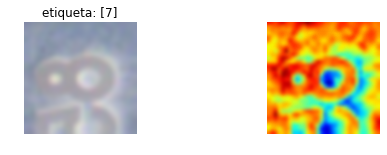

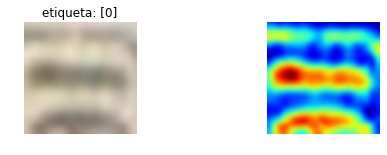

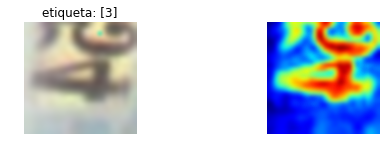

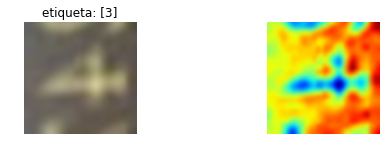

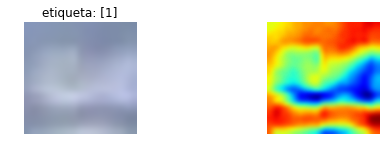

Para Test set


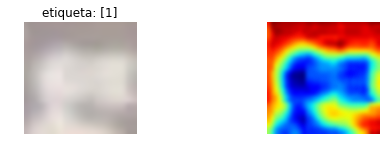

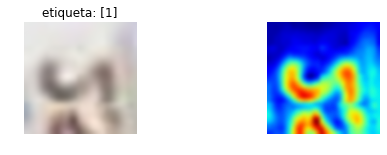

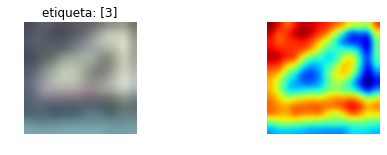

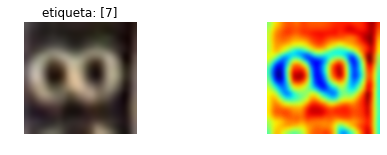

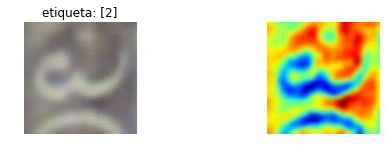

In [14]:
def ver_imagen(X,Y,n):
    aux = X[n].reshape(3,1024).copy()
    imagen = np.zeros((32,32,3))
    canal_r = aux[0].reshape(32,32)
    canal_g = aux[1].reshape(32,32)
    canal_b = aux[2].reshape(32,32)
    for i in range(len(aux)):
        imagen[:,:,i] = aux[i].reshape(32,32)
    
    import matplotlib.pyplot as plt
    f,ax = plt.subplots(1,2,figsize=(8,2))
    ax[0].set_title("etiqueta: "+str(Y[n]))
    ax[0].axis('off')
    ax[0].imshow(imagen, interpolation="bicubic")

    ax[1].axis('off')
    ax[1].imshow(canal_r, interpolation="bicubic")
    ax[1].imshow(canal_g, interpolation="bicubic")
    ax[1].imshow(canal_b, interpolation="bicubic")
    plt.show()

print "Para Training set"
np.random.seed(145)
numeros_random = np.random.randint(X_train.shape[0],size=5)
for numero in numeros_random:
    ver_imagen(X_train,y_train,numero)

print "Para Test set"
np.random.seed(151)
numeros_random = np.random.randint(X_test.shape[0],size=5)
for numero in numeros_random:
    ver_imagen(X_test,y_test,numero)

## B) Normalizar

In [3]:
from keras.utils import np_utils
X_train /= 255.0
X_test /= 255.0
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [8]:
print X_train.shape

(73257, 3, 32, 32)


## C) Definir y entrenar red

In [4]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD, Adadelta, Adagrad

model = Sequential()
model.add(Convolution2D(16, 5, 5, border_mode='same', activation='relu', input_shape=(3, 32, 32)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(512, 7, 7, border_mode='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

/usr/local/lib/python2.7/dist-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/usr/local/lib/python2.7/dist-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/usr/local/lib/python2.7/dist-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 32, 32)    1216        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 16, 16)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 512, 16, 16)   401920      maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
maxpooling2d_2 (MaxPooling2D)    (None, 512, 8, 8)     0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [5]:
adagrad = Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adagrad, metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=1280, nb_epoch=12, verbose=1, validation_data=(X_test, Y_test))

Train on 73257 samples, validate on 26032 samples
Epoch 1/12
10240/73257 [===>..........................] - ETA: 4488s - loss: 2.1439 - acc: 0.8447

MemoryError: 
Apply node that caused the error: Dot22(Elemwise{Composite{(i0 + (i1 * sgn(i2)))}}[(0, 2)].0, dense_1_W.T)
Toposort index: 87
Inputs types: [TensorType(float32, matrix), TensorType(float32, matrix)]
Inputs shapes: [(1280, 20), (20, 32768)]
Inputs strides: [(80, 4), (4, 80)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Reshape{4}(Dot22.0, MakeVector{dtype='int64'}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [ ]:
print "\nVALIDATION ERROR (activation relu-softmax) = %f"% model.evaluate(X_test, Y_test)

## D) Modificación del filtro

## E) Modificación filtro en capa Convolucional

## F) Nueva red

## G) Visualizar efecto pesos

## H) Ejemplos confusión

## I) Utilizar Extra (*Bonus*)